# Кластеризация
__Суммарное количество баллов: 10__

В этом домашнем задании предлагается реализовать три различных метода кластеризации, понять, в каких случаях стоит применять те или иные методы.

In [25]:
from sklearn.neighbors import KDTree
from sklearn.datasets import make_blobs, make_moons, make_swiss_roll
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib
import copy
import cv2
from collections import deque
import math
import statistics

In [40]:
def visualize_clasters(X, labels):
    unique_labels = np.unique(labels)
    unique_colors = np.random.random((len(unique_labels) + 100, 3))
    colors = [unique_colors[l] for l in labels]
    plt.figure(figsize=(9, 9))
    plt.scatter(X[:, 0], X[:, 1], c=colors)
    plt.show()

def clusters_statistics(flatten_image, cluster_colors, cluster_labels):
    fig, axes = plt.subplots(3, 2, figsize=(12, 16))
    for remove_color in range(3):
        axes_pair = axes[remove_color]
        first_color = 0 if remove_color != 0 else 2
        second_color = 1 if remove_color != 1 else 2
        axes_pair[0].scatter([p[first_color] for p in flatten_image], [p[second_color] for p in flatten_image], c=flatten_image, marker='.')
        axes_pair[1].scatter([p[first_color] for p in flatten_image], [p[second_color] for p in flatten_image], c=[cluster_colors[c] for c in cluster_labels], marker='.')
        for a in axes_pair:
            a.set_xlim(0, 1)
            a.set_ylim(0, 1)
    plt.show()

Генерируем два синтетических набора данных для кластеризации. Далее будем тестировать наши алгоритмы на них.

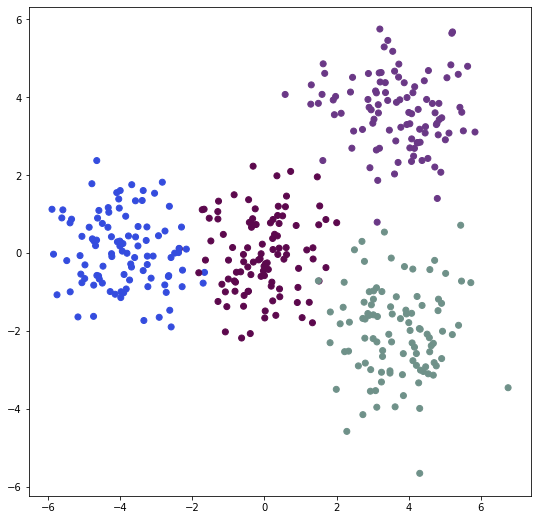

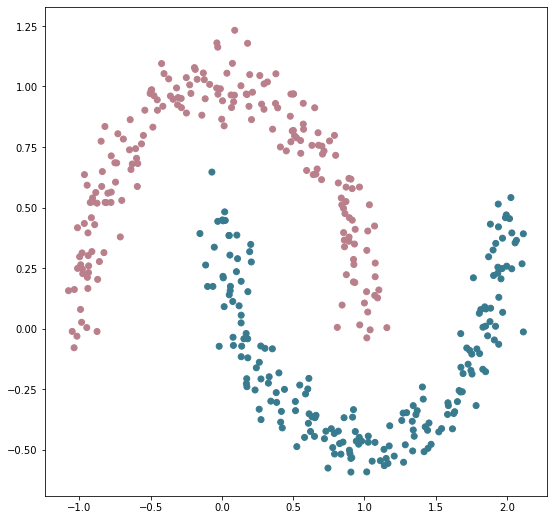

In [41]:
X_1, true_labels = make_blobs(400, 2, centers=[[0, 0], [-4, 0], [3.5, 3.5], [3.5, -2.0]])
visualize_clasters(X_1, true_labels)
X_2, true_labels = make_moons(400, noise=0.075)
visualize_clasters(X_2, true_labels)

### Задание 1 (2 балла)
Первый метод, который предлагается реализовать - метод K средних.

#### Описание методов
`fit(X, y=None)` ищет и запоминает в `self.centroids` центроиды кластеров для набора данных.
`predict(X)` для каждого элемента из `X` возвращает номер кластера, к которому относится данный элемент.

#### Инициализация кластеров
Есть несколько вариантов инициализации кластеров. Нужно реализовать их все:
1. `random` - центроиды кластеров являются случайными точками
2. `sample` - центроиды кластеров выбираются случайно из набора данных
3. `k-means++` - центроиды кластеров инициализируются при помощи метода K-means++


In [84]:
class KMeans:
    def __init__(self, n_clusters, init="random", max_iter=300):
        self.n_clusters = n_clusters
        self.init = init
        self.max_iter = max_iter
        self.centroids = []
        
    def fit(self, X, y=None):
        if self.init == "random":
            for i in range(self.n_clusters):
                self.centroids.append([random.uniform(min(list(zip(*X))[0][:]), max(list(zip(*X))[0][:])),random.uniform(min(list(zip(*X))[1][:]), max(list(zip(*X))[1][:]))]) 
        if self.init == "sample":
            for i in range(self.n_clusters):
                self.centroids.append(random.choice(X))
        if self.init == "k-means++":
            self.centroids.append(random.choice(X))
            for i in range(self.n_clusters - 1):
                X_el = []
                for element in X:
                    min_r = math.inf
                    for cl in range(len(self.centroids)):
                        if math.sqrt((element[0] - self.centroids[cl][0])**2 + (element[1] - self.centroids[cl][1])**2) < min_r:
                            min_r = math.sqrt((element[0] - self.centroids[cl][0])**2 + (element[1] - self.centroids[cl][1])**2)
                    X_el.append(min_r**2)
                self.centroids.append(random.choices(X, weights = X_el, k = 1)[0])
            
    def predict(self, X):
        while self.max_iter != 0:
            centroids_dict = {}
            min_r = math.inf
            min_cl = -1
            X_cl = []
            for element in X:
                min_r = math.inf
                for cl in range(len(self.centroids)):
                    if math.sqrt((element[0] - self.centroids[cl][0])**2 + (element[1] - self.centroids[cl][1])**2) < min_r:
                        min_r = math.sqrt((element[0] - self.centroids[cl][0])**2 + (element[1] - self.centroids[cl][1])**2)
                        min_cl = cl
                X_cl.append(min_cl)
                centroids_dict.setdefault(cl, []).append(element)
            
            for cl in range(len(self.centroids)):
                if len(centroids_dict.setdefault(cl, [])) != 0:self.centroids[cl] = [statistics.mean(list(zip(*centroids_dict[cl]))[0][:]), statistics.mean(list(zip(*centroids_dict[cl]))[1][:])]
            
            self.max_iter -= 1  
        return X_cl
            
        
        
        
        

Протестируйте алгоритм на синтетических данных. При необходимости подберите гиперпараметры для достижения лучшего качества кластеризации.

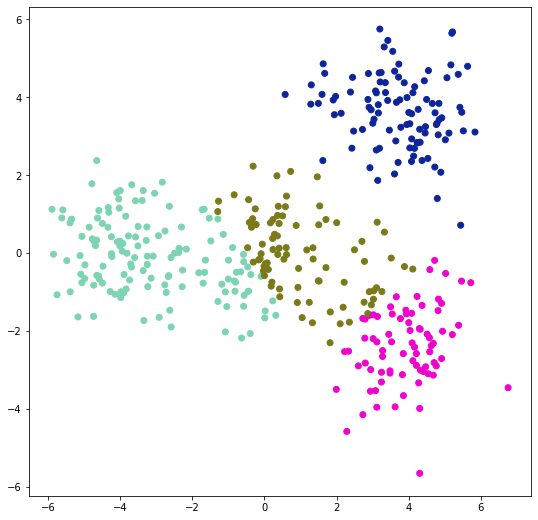

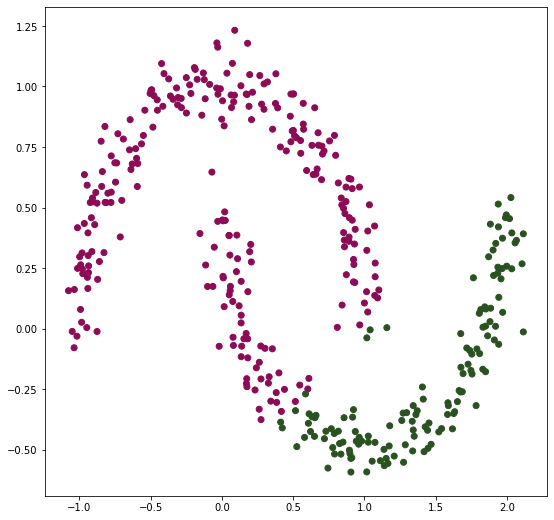

In [147]:
kmeans = KMeans(n_clusters=4, init="k-means++")
kmeans.fit(X_1)
labels = kmeans.predict(X_1)
visualize_clasters(X_1, labels)

kmeans = KMeans(n_clusters=2)
kmeans.fit(X_2)
labels = kmeans.predict(X_2)
visualize_clasters(X_2, labels)

### Задание 2 (4 балла)
В отличии от K-means, DBScan не позволяет задать количество кластеров, на которое будут разбиты данные. Руководствуясь геометрической интерпретацией, он позволяет выделять кластеры более сложной формы.

#### Описание методов
`fit_predict(X, y=None)` для каждого элемента `X` возвращает метку кластера, к которому он относится.

#### Возможные метрики
* `euclidean`
* `manhattan`
* `chebyshev`

__Для быстрого поиска соседей используйте `sklearn.neighbors.KDTree`__

In [137]:
class DBScan:
    def __init__(self, eps=0.5, min_samples=5, leaf_size=40, metric="euclidean"):
        self.eps = eps
        self.min_samples = min_samples
        self.leaf_size = leaf_size
        self.metric = metric
        
    def fit_predict(self, X, y=None):
        n = len(X)
        tree = KDTree(X, self.leaf_size, self.metric)
        color = 0
        stack = []
        X_cl = [-1]*n
        for i in range(n):
            if X_cl[i] == -1:
                ind = tree.query_radius([X[i]], self.eps)[0]
                if len(ind) <= self.min_samples:
                    X_cl[i] = 0
                else:
                    color += 1
                    X_cl[i] = color
                    stack.extend(ind)
                    stack.remove(i)
                    while len(stack) != 0:
                        j = stack.pop()
                        ind = tree.query_radius([X[j]], self.eps)[0]
                        if len(ind) <= self.min_samples:
                            X_cl[j] = 0
                        else:
                            X_cl[j] = color
                            for neib in ind:
                                if X_cl[neib] == -1:
                                    stack.append(neib)
        return X_cl
            
        

Протестируйте алгоритм на синтетических данных. При необходимости подберите гиперпараметры для достижения лучшего качества кластеризации.

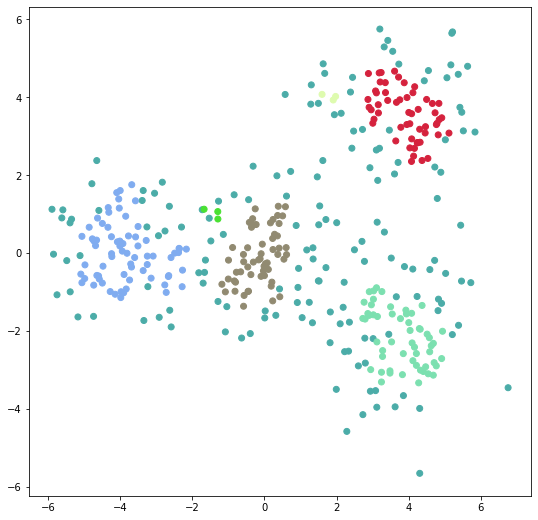

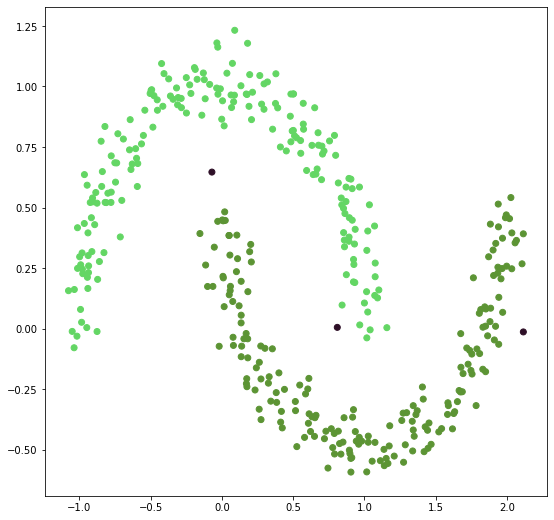

In [146]:
dbscan = DBScan()
labels = dbscan.fit_predict(X_1)
visualize_clasters(X_1, labels)

dbscan = DBScan(eps=0.2)
labels = dbscan.fit_predict(X_2)
visualize_clasters(X_2, labels)

### Задание 3 (4 балла)
Идея AgglomerativeClustering заключается в том, чтобы итеративно объединять кластеры с наименьшим расстоянием между ними. Данный метод обладает высокой вычислительной сложностью, поэтому применим только для относительно небольших наборов данных.

#### Описание методов
`fit_predict(X, y=None)` для каждого элемента `X` возвращает метку кластера, к которому он относится.

#### Linkage-функции
__Linkage__ - это способ, которым будет рассчитываться расстояние между кластерами. Предлагается реализовать три варианта такой функции:
1. `average` - расстояние рассчитывается как среднее расстояние между всеми парами точек, где одна принадлежит первому кластеру, а другая - второму.
2. `single` - расстояние рассчитывается как минимальное из расстояний между всеми парами точек, где одна принадлежит первому кластеру, а другая - второму.
2. `complete` - расстояние рассчитывается как максимальное из расстояний между всеми парами точек, где одна принадлежит первому кластеру, а другая - второму.

In [194]:
class AgglomertiveClustering:
    def __init__(self, n_clusters=16, linkage="average"):
        self.n_clusters = n_clusters
        self.linkage = linkage
    def average (self, A, B):
        sum_AB = 0
        for i in A:
            for j in B:
                sum_AB += math.sqrt((i[0] - j[0])**2 + (i[1] - j[1])**2)
        return sum_AB/(len(A)*len(B))
    def single (self, A, B):
        min_AB = math.inf
        for i in A:
            for j in B:
                if math.sqrt((i[0] - j[0])**2 + (i[1] - j[1])**2) < min_AB: 
                    min_AB = math.sqrt((i[0] - j[0])**2 + (i[1] - j[1])**2)
        return min_AB
    def complete (self, A, B):
        max_AB = 0
        for i in A:
            for j in B:
                if math.sqrt((i[0] - j[0])**2 + (i[1] - j[1])**2) > max_AB: 
                    max_AB = math.sqrt((i[0] - j[0])**2 + (i[1] - j[1])**2)
        return max_AB
    def dist(self, A, B):
        if self.linkage == "average":
            return self.average(A, B)
        if self.linkage == "single":
            return self.single(A, B)
        if self.linkage == "complete":
            return self.complete(A, B)
        
    def fit_predict(self, X, y=None):
        clusters = {}
        for el in X:
            clusters[(el[0], el[1])] = [el]
        while len(clusters.keys()) > self.n_clusters:
            min_dist = math.inf
            min_A = []
            min_B = []
            for i in clusters.keys():
                for j in clusters.keys():
                    if i[0] != j[0] or i[1] != j[1]:
                        dist_ij = self.dist(clusters[i], clusters[j])
                        if min_dist > dist_ij:
                            min_dist = dist_ij
                            min_A = i
                            min_B = j
            elements = clusters.pop(min_A)
            elements.extend(clusters.pop(min_B))
            x_0 = statistics.mean(list(zip(*elements))[0][:])
            y_0 = statistics.mean(list(zip(*elements))[1][:])
            clusters[(x_0, y_0)] = elements
        
        color = 0
        X = X.tolist()
        X_cl = [0]*len(X)
        for cl in clusters.keys():
            for elem in clusters[cl]:
                X_cl[X.index(elem.tolist())] = color
            color += 1
        return X_cl
                        
        


Протестируйте алгоритм на синтетических данных. При необходимости подберите гиперпараметры для достижения лучшего качества кластеризации.

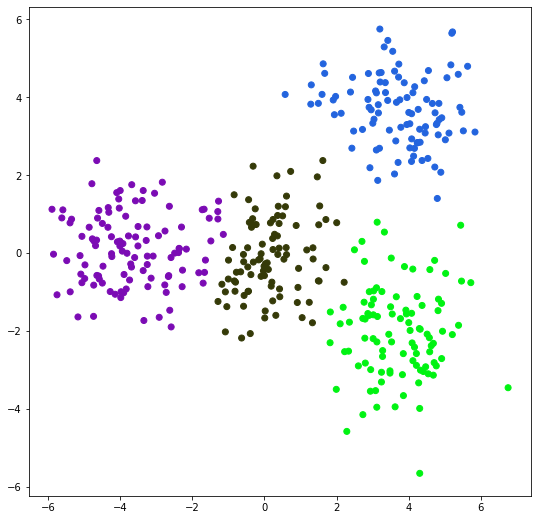

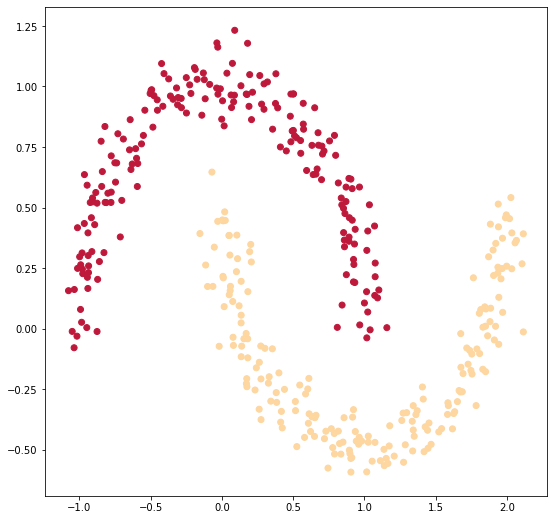

In [198]:
agg_clustering = AgglomertiveClustering(n_clusters=4)
labels = agg_clustering.fit_predict(X_1)
visualize_clasters(X_1, labels)

agg_clustering = AgglomertiveClustering(n_clusters=2, linkage="single")
labels = agg_clustering.fit_predict(X_2)
visualize_clasters(X_2, labels)